Датасет 'investing_program_prediction_data.csv' (https://www.kaggle.com/snassimr/data-for-investing-type-prediction/code). Данные были собраны в рамках реального проекта с целью предсказать, какую инвестиционную программу предложить клиенту инвестиционного банка. Банк решил, что будет очень полезно заранее спрогнозировать какой тип инвестиционной программы может подойти клиенту, а не пытаться предлагать все продукты подряд конкретному клиенту.

In [1]:
import numpy as np
import pandas as pd
import dill
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv("E:/GB/MLBiz/Term_paper/investing_program_prediction_data.csv")

_**EDA и feature engineering**_

In [3]:
print("Data dimensions:")
print(df.shape)
print("List of columns:")
print(df.columns)
print("Dataframe view:")
df.head()

Data dimensions:
(4734, 28)
List of columns:
Index(['SE1', 'SE2', 'BA1', 'BA2', 'BA3', 'BA4', 'BA5', 'BA6', 'BA7', 'PE1',
       'PE2', 'PE3', 'PE4', 'PE5', 'PE6', 'PE7', 'PE8', 'PE9', 'PE10', 'PE11',
       'PE12', 'PE13', 'PE14', 'PE15', 'IA1', 'IA2', 'IA3', 'InvType'],
      dtype='object')
Dataframe view:


,SE1,SE2,BA1,BA2,BA3,BA4,BA5,BA6,BA7,PE1,...,PE10,PE11,PE12,PE13,PE14,PE15,IA1,IA2,IA3,InvType
0,45,G29,12,0.0,5934,0,0,0,0,I0,...,I0,I0,I0,I0,I0,I0,0,0,1,C1
1,41,G0,0,0.0,21514,316374,5142,0,5141,I0,...,I0,I0,I1,I1,I1,I0,0,0,1,C1
2,43,G0,1,0.0,14324,22344,22344,0,22344,I0,...,I0,I0,I0,I0,I0,I0,0,0,0,C1
3,36,G52,16,0.0,41114,2406838,1156219,692875,41425,I0,...,I1,I1,I1,I1,I0,I0,0,0,0,C1
4,2,G10,0,0.0,2394,621,621,0,621,I0,...,I0,I0,I0,I0,I0,I0,0,0,0,C1


In [4]:
df.dtypes

SE1          int64
SE2         object
BA1          int64
BA2        float64
BA3          int64
BA4          int64
BA5          int64
BA6          int64
BA7          int64
PE1         object
PE2         object
PE3         object
PE4         object
PE5         object
PE6         object
PE7         object
PE8         object
PE9         object
PE10        object
PE11        object
PE12        object
PE13        object
PE14        object
PE15        object
IA1          int64
IA2          int64
IA3          int64
InvType     object
dtype: object

_**В некотором смысле это кошмар из зоопарка различных типов данных. Потребуется предобработка**_

Описание условных обозначений параметров:

SE1 (Age) , SE2 (Geographic location) - Customer data

BA1 – BA7 – Banking activity , money equivalent for general activities on customer’s bank account in last year , i.e. sum of payments for loan return

PE1 – PE15 – Investing history , flag if customer had one of 15 popular investment products/programs in last year

IA1 – IA3 – Investing activity , counts for different types of operations on investment accounts in last year

<AxesSubplot:>

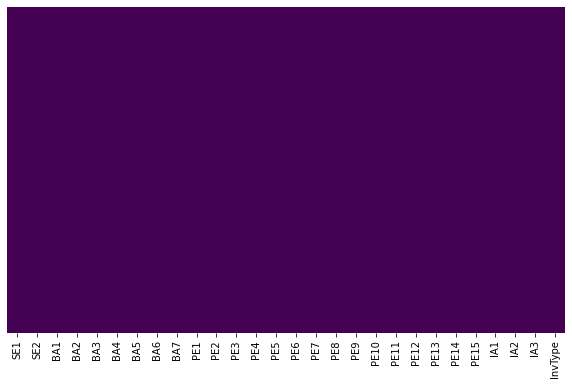

In [5]:
# Смотрим на наличие пропусков визульно и в буквенно-цифровом исполнении


plt.figure(figsize = (10, 6))
sns.heatmap(df.isna(), cbar = False, cmap = 'viridis', yticklabels = False)

In [6]:
for i in range(len(df.columns)):
    missing_data = df[df.columns[i]].isna().sum()
    perc = missing_data / len(df) * 100
    print('>%d,  пропуски: %d, процент %.2f' % (i, missing_data, perc))

>0,  пропуски: 0, процент 0.00
>1,  пропуски: 0, процент 0.00
>2,  пропуски: 0, процент 0.00
>3,  пропуски: 0, процент 0.00
>4,  пропуски: 0, процент 0.00
>5,  пропуски: 0, процент 0.00
>6,  пропуски: 0, процент 0.00
>7,  пропуски: 0, процент 0.00
>8,  пропуски: 0, процент 0.00
>9,  пропуски: 0, процент 0.00
>10,  пропуски: 0, процент 0.00
>11,  пропуски: 0, процент 0.00
>12,  пропуски: 0, процент 0.00
>13,  пропуски: 0, процент 0.00
>14,  пропуски: 0, процент 0.00
>15,  пропуски: 0, процент 0.00
>16,  пропуски: 0, процент 0.00
>17,  пропуски: 0, процент 0.00
>18,  пропуски: 0, процент 0.00
>19,  пропуски: 0, процент 0.00
>20,  пропуски: 0, процент 0.00
>21,  пропуски: 0, процент 0.00
>22,  пропуски: 0, процент 0.00
>23,  пропуски: 0, процент 0.00
>24,  пропуски: 0, процент 0.00
>25,  пропуски: 0, процент 0.00
>26,  пропуски: 0, процент 0.00
>27,  пропуски: 0, процент 0.00


Пропусков нет. Хороший датасет. Спасибо автору.

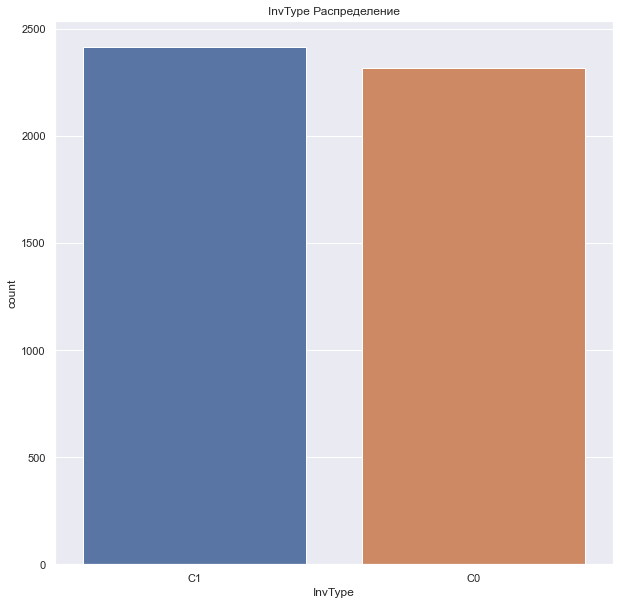

In [7]:
# распределение предлагаемых пакетов по группам клиентов (как позже выяснилось, пакетов всего 2, но сделаем вид, что мы 
# пока еще не знаем об этом)

target = "InvType"
fig = plt.figure(figsize=(10,10))
sns.set(style="darkgrid")
ax = sns.countplot(x = target, data = df).set_title(target + " " + "Распределение")

Примерно равное распределение. Наверное это хорошо.

_**Предподготовка данных и построение pipeline**_

In [8]:
%%time

X_train, X_test, y_train, y_test = train_test_split(df, df['InvType'], test_size=0.33, random_state=42)

#save test
X_test.to_csv("E:/GB/MLBiz/Term_paper/X_test.csv", index=None)
y_test.to_csv("E:/GB/MLBiz/Term_paper/y_test.csv", index=None)
#save train
X_train.to_csv("E:/GB/MLBiz/Term_paper/X_train.csv", index=None)
y_train.to_csv("E:/GB/MLBiz/Term_paper/y_train.csv", index=None)


numeric_features = ['SE1', 'BA1', 'BA2', 'BA3', 'BA4', 'BA5', 'BA6', 'BA7', 'IA1', 'IA2', 'IA3']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['SE2', 'PE1', 'PE2', 'PE3', 'PE4', 'PE5', 'PE6', 'PE7', 'PE8', 'PE9', 'PE10', 'PE11', 'PE12', 'PE13',
                       'PE14', 'PE15']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


#clf = Pipeline([
#    ('preprocessor', preprocessor),
#    ('classifier', LogisticRegression()),
#])

#clf.fit(X_train, y_train)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

clf.fit(X_train, y_train)

print("model score: %.3f" % clf.score(X_test, y_test))
clf.steps

model score: 0.678
Wall time: 443 ms


[('preprocessor',
  ColumnTransformer(transformers=[('num',
                                   Pipeline(steps=[('imputer',
                                                    SimpleImputer(strategy='median')),
                                                   ('scaler', StandardScaler())]),
                                   ['SE1', 'BA1', 'BA2', 'BA3', 'BA4', 'BA5',
                                    'BA6', 'BA7', 'IA1', 'IA2', 'IA3']),
                                  ('cat', OneHotEncoder(handle_unknown='ignore'),
                                   ['SE2', 'PE1', 'PE2', 'PE3', 'PE4', 'PE5',
                                    'PE6', 'PE7', 'PE8', 'PE9', 'PE10', 'PE11',
                                    'PE12', 'PE13', 'PE14', 'PE15'])])),
 ('classifier', LogisticRegression())]

In [9]:
# лучше смотреть на картинку pipeline, потому что так нагляднее

from sklearn import set_config

set_config(display='diagram')
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SE1', 'BA1', 'BA2', 'BA3',
                                                   'BA4', 'BA5', 'BA6', 'BA7',
                                                   'IA1', 'IA2', 'IA3']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['SE2', 'PE1', 'PE2', 'PE3',
                                                   'PE4', 'PE5', 'PE6', 'PE7',
                                                   'PE8', 'PE9', 'PE10', 'PE11',
                                                   'PE12', 'PE13', 'PE14',
                                                   'PE15'])])),
                ('classifier', LogisticRegression())])

In [10]:
with open("E:/GB/MLBiz/Term_paper/logreg_pipeline.dill", "wb") as f:
    dill.dump(clf, f)